In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

DATA_SET="/content/drive/My Drive/GDFiles/Stage_2"
CATEGORIES=["Memes","Notes"]


In [4]:
data=[]

IMG_SIZE=64

for category in CATEGORIES:
  folder=os.path.join(DATA_SET,category)
  label=CATEGORIES.index(category)
  for img in os.listdir(folder):
      img_path=os.path.join(folder,img)
      img_array=cv2.imread(img_path)
      img_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      data.append([img_array,label])

In [5]:
random.shuffle(data)

X=[]
Y=[]

for features,labels in data:
    X.append(features)
    Y.append(labels)
X=np.array(X)
Y=np.array(Y) 

  

In [19]:
X_train=X[:1000]
Y_train=Y[:1000]
X_val=X[1000:1300]
Y_val=Y[1000:1300]
X_test=X[1300:1600]
Y_test=Y[1300:1600]
#print(Y_train.shape)
#print(X_val.shape)
#print(X_test.shape)
#X_train[0]

X_train=X_train/255 #Normalisation
X_val=X_val/255     #Normalisation
X_test=X_test/255   #Normalisation

#RESHAPING ALL THE X AND Y
X_train=X_train.reshape(X_train.shape[0],-1).T
Y_train=Y_train.reshape(1,Y_train.shape[0])
X_val=X_val.reshape(X_val.shape[0],-1).T
Y_val=Y_val.reshape(1,Y_val.shape[0])
X_test=X_test.reshape(X_test.shape[0],-1).T
Y_test=Y_test.reshape(1,Y_test.shape[0])
print(X_train.shape)
print(X_train[:,0*50:(1)*50].shape)


(12288, 1000)
(12288, 50)


#INITIALISING PARAMETERS

In [7]:
def initialise_param(layers):
   parameters={}
   for i in range(1,len(layers)):
     parameters['W'+str(i)] = np.random.randn(layers[i],layers[i-1]) * 0.01
     parameters['b'+str(i)] = np.zeros((layers[i],1))
   return parameters  



In [8]:
def reLu(x):
	return np.maximum(0, x)


In [9]:
def forward_prop(parameters,X_train,layers):
    z = {}
    ac = {}
    ac['A0'] = X_train
    for i in range(1,len(layers)):
        z['Z'+str(i)] = np.dot(parameters['W'+str(i)],ac['A'+str(i-1)]) + parameters['b'+str(i)]
        ac['A'+str(i)] = reLu(z['Z'+str(i)])
    return z,ac


In [10]:
def relu_deriv(z):
    z[z > 0] = 1
    z[z <= 0] = 0
    return z


def back_prop(X_train,Y_train,parameters,ac,layers,z):
  grads = {} #dictionary containing gradients
  m = Y_train.shape[1]  #No of examples
  for i in range(1,len(layers)):
    if i==1:
      grads['dZ'+str(len(layers)-1)] = ac['A'+str(len(layers)-1)] - (Y_train)
      grads['dW'+str(len(layers)-1)] = (1/m) * np.dot(grads['dZ'+str(len(layers)-1)],ac['A'+str(len(layers)-2)].T)
      grads['db'+str(len(layers)-1)] = (1/m) * np.sum(grads['dZ'+str(len(layers)-1)],axis=1,keepdims=True)
    else:
      grads['dZ'+str(len(layers) - i)] = np.dot(parameters['W'+str(len(layers)-i+1)].T,grads['dZ'+str(len(layers)-i+1)])*(relu_deriv(ac['A'+str(len(layers)-i)]))
      grads['dW'+str(len(layers)-i)] = (1/m) * np.dot(grads['dZ'+str(len(layers)-i)],ac['A'+str(len(layers)-i-1)].T)
      grads['db'+str(len(layers)-i)] = (1/m) * np.sum(grads['dZ'+str(len(layers)-i)],axis=1,keepdims=True)
  return grads    
      
    






In [11]:
def cost_finder(ac,Y_train,layers):
    AL = ac['A'+str(len(layers)-1)]
    cost = (-1/Y_train.shape[1])*np.sum((Y_train)*np.log(AL+0.1) + (1-(Y_train))*np.log(AL+0.1))
    return cost

In [27]:
def training(X_train,Y_train,layers,epochs,learning_rate=0.01):
  costs_epoch=[]
  #getting parameters
  parameters=initialise_param(layers)
  mini_batch=50
  m=Y_train.shape[1]
  for i in range(epochs):
    for j in range(int(m/mini_batch)):
      z,ac=forward_prop(parameters,X_train[:,j*mini_batch:(j+1)*mini_batch],layers)
      cost=cost_finder(ac,Y_train[:,j*mini_batch:(j+1)*mini_batch],layers)
      costs_epoch.append(cost)
      grads=back_prop(X_train[:,j*mini_batch:(j+1)*mini_batch],Y_train[:,j*mini_batch:(j+1)*mini_batch],parameters,ac,layers,z)
      for k in range(1,len(layers)):
                parameters['W'+str(k)] -= learning_rate*grads['dW'+str(k)]
                parameters['b'+str(k)] -= learning_rate*grads['db'+str(k)]
    print(costs_epoch)
    
  #printing accuracy per epoch
    final_parameters=parameters
    _ , ac = forward_prop(final_parameters,X_train,layers)
    A = ac['A'+str(len(layers)-1)]  

    A = (A > 0.5).astype(int)

    preds = (A == Y_train).astype(int)
    accuracy = (np.sum(preds)/preds.shape[1])
    print(accuracy)
  plt.plot(costs_epoch,'-x')
  plt.ylabel('cost value')
  plt.xlabel('epoch')
  plt.show()   

  



In [ ]:
layers = [12288,1000,50,1] 
trained_parameters = training(X_train,Y_train,layers,30) # define epochs here

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 4.314893199773047, 4.201507969864302, 4.1010877568615465, 4.010558083860836, 3.928161092088174, 3.852466358772939, 3.7825755283024303, 3.7176413860000865, 3.6570783108577545]
0.494
[3.6002544888051617, 3.546675385650548, 3.4959407166023353, 3.4477069270587637, 3.4017199720157425, 3.357783538353846, 3.3157364419123136, 3.2753560361907765, 3.2365412991621065, 3.1991539331401073, 3.1631105314046435, 3.1283036373319337, 3.0946300707711303, 3.0619865024069712, 3.0303138681207713, 2.999537781771305, 2.969609559327096, 2.9404655309925145, 2.912040856670683, 2.8842954983527616]
0.494
[2.8571801929745666, 2.8306564267087415, 2.8046966667601674, 2.779261209365002, 2.7543271706259405, 2.72985210049944, 2.705810710944509, 2.6821885560051033, 2.6589574580448403, 2.636093356238855, 2.613578141930318, 2.5913948634055983, 2.5695255614827506, 2.547954678408447, 2.526670221553875, 2.5056617845805813, 2.484919142424809, 2.4644334715292424, 2.4441920

In [ ]:
training(X_val,Y_val,layers,20)

[2.298748806712099, 2.2954145091354095, 2.2902724647635226, 2.2828120728255508, 2.2740261952185334, 2.264596114498195, 2.2548697908062385, 2.2449912200070097, 2.23513706297001, 2.2253807953265277, 2.2156916281194654, 2.2060985078793185, 2.196597893632821, 2.187179745413824, 2.17784501556131]
0.5166666666666667
[2.168589054144901, 2.1594092487371883, 2.150302427181462, 2.1412663903083655, 2.132300828211174, 2.1234010074060796, 2.114565809603192, 2.105794257684435, 2.097081579400231, 2.0884239042732102, 2.0798207536042956, 2.071270565603091, 2.0627694787474327, 2.054315813361176, 2.045905613512006]
0.5166666666666667
[2.037538064372119, 2.029208885493691, 2.020917464573425, 2.0126591042852255, 2.004432861791646, 1.996237202564092, 1.988073803305453, 1.9799415515710561, 1.9718375553881993, 1.963760346164789, 1.955706877632973, 1.947673823891368, 1.939660924314338, 1.9316696468948886, 1.9236978587865987]
0.5166666666666667
[1.9157453788319172, 1.9078118835201945, 1.8998958590967445, 1.8919

In [ ]:
training(X_test,Y_test,layers,35)

[2.302496438782525, 2.3024043057410037, 2.302175288253796, 2.301736410880645, 2.300715519040052, 2.299113372021871, 2.296673745110354, 2.291744532027936, 2.2827723924100844, 2.2699352390210144, 2.255332278588135, 2.239844965339235, 2.224411068430477, 2.2089182131479137, 2.19351689464827]
0.5033333333333333
[2.178365837922222, 2.1634914494815556, 2.1488707167179975, 2.134492779362146, 2.1203494512478365, 2.1064254739141135, 2.092706119114472, 2.0791849014455113, 2.0658510381832413, 2.0526956620945143, 2.0397040848945713, 2.0268693765626558, 2.014189783630952, 2.0016587986281533, 1.9892705225050502]
0.5033333333333333
[1.977019227248306, 1.964898975391659, 1.952903937391562, 1.941028299127988, 1.929267131001459, 1.9176162221822777, 1.9060715378575053, 1.8946280093975294, 1.8832813079850015, 1.8720358808471604, 1.8608941094041151, 1.8498398404713756, 1.8388645451343777, 1.8279731569648752, 1.8171670168984946]
0.5033333333333333
[1.806438570224478, 1.7957819079964414, 1.785191589328277, 1.

# TRAINING SET WITH GRAPH


[2.3025850929940455, 2.3025850929940455, 2.3025781473277016, 2.3020421732357925, 2.299485782518659, 2.3006221653602617, 2.2985072373575464, 2.2948893560282055, 2.2916109028869434, 2.2811904716022138, 2.2704485629995883, 2.2599018413984893, 2.2518882993789533, 2.2395947914488583, 2.2406149219870297, 2.2336891350250725, 2.217537546877515, 2.2073392315867624, 2.1923643455435946, 2.1891265372883653]
0.51
[2.3025850929940455, 2.3025850929940455, 2.3025781473277016, 2.3020421732357925, 2.299485782518659, 2.3006221653602617, 2.2985072373575464, 2.2948893560282055, 2.2916109028869434, 2.2811904716022138, 2.2704485629995883, 2.2599018413984893, 2.2518882993789533, 2.2395947914488583, 2.2406149219870297, 2.2336891350250725, 2.217537546877515, 2.2073392315867624, 2.1923643455435946, 2.1891265372883653, 2.1783226511218756, 2.164332346148081, 2.1595480698698264, 2.1483580400188558, 2.1301946624342394, 2.1289021674702076, 2.1219675017269246, 2.1108079871336654, 2.100699156050701, 2.089090541369085, 

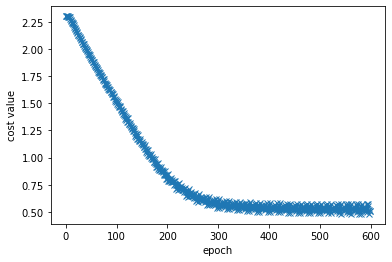

In [25]:
layers = [12288,1000,50,1] 
trained_parameters = training(X_train,Y_train,layers,30)

# VALIDATION SET WITH GRAPH


[2.2451537230710876, 2.1374243352676894, 2.038615249711597, 1.9401622643437377, 1.8692190972496412, 1.788035326423223]
0.43333333333333335
[2.2451537230710876, 2.1374243352676894, 2.038615249711597, 1.9401622643437377, 1.8692190972496412, 1.788035326423223, 1.6827047035419689, 1.5701115145534832, 1.4924343554031823, 1.3841028658390502, 1.3065227076687962, 1.2405684544976943]
0.43333333333333335
[2.2451537230710876, 2.1374243352676894, 2.038615249711597, 1.9401622643437377, 1.8692190972496412, 1.788035326423223, 1.6827047035419689, 1.5701115145534832, 1.4924343554031823, 1.3841028658390502, 1.3065227076687962, 1.2405684544976943, 1.1138950612305474, 0.9921500355020143, 0.9377069896187143, 0.8360075382891705, 0.7879777195023931, 0.7619080531512095]
0.62
[2.2451537230710876, 2.1374243352676894, 2.038615249711597, 1.9401622643437377, 1.8692190972496412, 1.788035326423223, 1.6827047035419689, 1.5701115145534832, 1.4924343554031823, 1.3841028658390502, 1.3065227076687962, 1.2405684544976943,

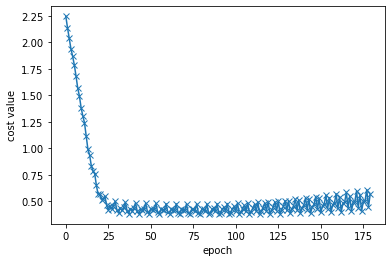

In [28]:
layers = [12288,1000,50,1] 
trained_parameters = training(X_val,Y_val,layers,30)